In [1]:
import torch
from matplotlib import pyplot as plt

print("PyTorch has version {}".format(torch.__version__))
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

import numpy as np
import os
import shutil

from tqdm import trange
import copy

from torch_geometric.loader import DataLoader

torch.manual_seed(1)
np.random.seed(1)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)
print()

PyTorch has version 1.13.1+cu117
Using device: cuda



## Graph generation
Here, we generate many graphs in the DIMACS minimum cost flow structure. Any minimum cost flow problem in this representation can be used for training.
More specifics on the file representation: [DIMACS minimum cost flow problem structure](https://lpsolve.sourceforge.net/5.5/DIMACS_mcf.htm)

In [2]:
from graph_generator import generate_min_cost_flow_graphs

generate_min_cost_flow_graphs(num = 1000, dst_folder = "./data/raw")

Generating 1000 min cost flow graphs
Done!


## Pytorch geometric dataset
The MinCostDataset class is a custom pytorch geometric dataset class that allows us to transform networks from the DIMACS problem structure into the graph format expected by PyG. By running this cell, network txt files in the root folder will be automatically processed and stored in `./data/processed/`.

In [3]:
from MinCostDataset import MinCostDataset

dataset = MinCostDataset(root = "./data/")

In [4]:
def dataset_information(dataset):
    """Print some basic information about the dataset"""
    print(f"number of graphs: {dataset.len()}")
    print(f"number of node features: {dataset.num_features}")
    print(f"number of edge features: {dataset.num_edge_features}")
    print(f"first graph: {dataset[0]}")

dataset_information(dataset)

number of graphs: 1000
number of node features: 1
number of edge features: 2
first graph: Data(x=[52, 1], edge_index=[2, 113], edge_attr=[113, 2], y=[52, 2], reduced_cost=[113, 2], filename='netgen_249.txt')


## Dataset split
Since we are not working with a predefined dataset, we have to manually create training, testing, and validation splits. Since we are ultimately trying to make predictions on new, unseen networks, we split at the level of graphs instead of nodes/edges.

In [5]:
def train_test_validation_split(dataset, train = 0.7, validation = 0.15):
    """
    Splits a dataset into a training, validation, and test split. The test fraction is 1 - train - validation.
    Similar to sklearn.model_selection.train_test_split with the addition to a validation split.
    Args:
        dataset: dataset to split
        train: fraction of the dataset to allocate to training
        validation: fraction of the dataset to allocate to validation

    Returns:
        An index for each train/validation/test datasets.
    """
    length = dataset.len()
    shuffled_dataset = np.arange(length)
    np.random.shuffle(shuffled_dataset)

    train_cutoff = int(train * length)
    validation_cutoff = int((train + validation) * length)

    train_data = shuffled_dataset[:train_cutoff]
    validation_data = shuffled_dataset[train_cutoff: validation_cutoff]
    test_data = shuffled_dataset[validation_cutoff:]

    return train_data, validation_data, test_data

In [6]:
def create_split_directories(dataset, split, split_name):
    """
    Creates a new directory for the dataset and saves each corresponding file into it.
    Args:
        dataset: dataset from which to copy the files
        split: indices of the files to move to the new directory
        split_name: name of the new directory
    """

    src_folder = dataset.processed_dir
    dst_folder = os.path.join(dataset.root, split_name)

    # Remove files in case some were already present
    if os.path.exists(dst_folder):
        shutil.rmtree(dst_folder)
    os.makedirs(dst_folder)

    # Files are always expected by PyG to be ordered from 0 to length of the dataset so we have to
    # reorder them in the new directory
    dst_index = 0
    for file_id in split:
        src_file_name = f"data_{file_id}.pt"
        dst_file_name = f"data_{dst_index}.pt"
        src = os.path.join(src_folder, src_file_name)
        dst = os.path.join(dst_folder, dst_file_name)
        shutil.copyfile(src, dst)
        dst_index += 1

def split_dataset(dataset, train_frac = 0.7, validation_frac = 0.15):
    """
    Partitions a dataset into 3 folders: data_train, data_test, data_validation such that each contains
    a certain fraction of the graphs.
    Args:
        dataset: dataset to split
        train_frac: fraction of the graphs to put into the training folder
        validation_frac: fraction of the graphs ot put into the validation folder
    Note: test_frac is implicitly defined as 1 - train_frac - validation frac
    """

    train, validation, test = train_test_validation_split(dataset, train_frac, validation_frac)
    create_split_directories(dataset, train, "data_train/processed")
    create_split_directories(dataset, test, "data_test/processed")
    create_split_directories(dataset, validation, "data_validation/processed")


split_dataset(dataset, train_frac = 0.7, validation_frac = 0.15)

## Loss functions
We define the different loss functions we have experimented with for learning duals. The first (DualLoss) pools over all predicted node potentials (a scalar value predicted for each node) then computes the objective value of the dual in the graph. The corresponding formula comes directly from the objective of the Lagrangian dual problem for MCF:
$$\widehat{\text{OPT}} = -\sum_{i \in V} b_i\hat{y}_i - \sum_{(i,j) \in E} u_{ij} \cdot \max(0, \hat{y}_j - \hat{y}_i - c_{ij})$$
Loss is then computed by:
$$\text{LOSS} (\text{OPT}, \widehat{\text{OPT}}) = \text{OPT} - \widehat{\text{OPT}}$$
Notice that we don't add a norm on the substraction since, by weak duality $\text{LOSS}(\text{OPT}, \widehat{\text{OPT}}) \geq 0$ with $\text{LOSS}(\text{OPT}, \widehat{\text{OPT}}) = 0$ if and only if $\hat{y}$ is a dual-optimal solution.


In [7]:
class DualLoss(nn.Module):
    """
    This loss function computes the objective value of the learned duals following the above formula with an optional regularization factor.
    """

    def __init__(self):
        super(DualLoss, self).__init__()

    def forward(self, pred, label, x, edge_index, edge_attr, gamma = 0.0005):
        """
        Computes the dual loss
        Args:
            pred: predicted node potentials
            label: optimal dual value in the graphs
            x: original node features (we need to know the demand of each node to compute the loss)
            edge_index: edge structure of the graph
            edge_attr: original edge features (we need to know the cost and capacity of each edge to compute the loss)
            gamma: regularization factor to push learned potentials towards more 0 reduced cost edges

        Returns:
            the corresponding loss value
        """
        reduced_cost = edge_attr[:, 1] + pred[edge_index[0]].squeeze() - pred[edge_index[1]].squeeze()
        opt = label[0, 0]  # Optimal dual value in the graph

        # PyTorch retranscription of the above equation, notice that the loss is divided by the optimal dual value
        # to make it independent of graph size
        loss = (opt + torch.dot(pred.squeeze(), x.squeeze()) + torch.dot(edge_attr[:, 0],
                                                                             F.relu(-reduced_cost))) / opt

        # Add regularization to avoid having too many negative reduced-cost edges
        reg = gamma * sum(F.relu(-reduced_cost))

        return loss + reg

#### Edge reduced cost loss
Instead of trying to predict node potential values, here we try to predict if a given edge will have negative reduced cost or positive reduced cost (this information can then used to "warm-start" the algorithm). In this case, we are essentially doing edge classification so the loss definition is much simpler, simply computing a weighted cross entropy.

In [8]:
class EdgeReducedCostLoss(nn.Module):
    def __init__(self, weight = None):
        """
        Args:
            weight: weighs the different classes differently, useful for an unbalanced dataset (which is the case here)
        """
        super(EdgeReducedCostLoss, self).__init__()
        self.loss_fn = nn.CrossEntropyLoss(weight = weight)

    def forward(self, preds, labels):
        return self.loss_fn(preds, labels)


#### Potential loss
This loss function is most similar to the first one (DualLoss). However, here, instead of learning duals such that their objective value is close to optimal, we learn dual values that are close to a set of optimal dual values. This transforms the task from a graph-level regression to a node-level regression.

We note that this approach may seem theoretically unsound, there are indeed several possible sets of optimal dual values possible, all attaining optimal objective value so learning exactly one set seems illogical. However, empirically, this method is the one that works best. From experiments, it seems to be because DualLoss had a much higher noise to signal ratio. This makes sense intuitively, here we predict one value per node whereas in DualLoss, we essentially predict one value for the entire graph then expect to backpropagate this single scalar value to the thousands of parameters in the GNN.

In [9]:
class PotentialLoss(nn.Module):
    """
    Simplest loss: it just returns the L1 difference between a set of optimal dual values (that is, a scalar value per node in the graph)
    and the computed duals
    """

    def __init__(self):
        super(PotentialLoss, self).__init__()

    def forward(self, preds, labels):
        return torch.linalg.vector_norm(preds.squeeze() - labels, ord = 1)

In [10]:
def accuracy(preds, labels):
    """
    For edge-level classification, computes the accuracy of the predictions
    Args:
        preds: predicted edge classes
        labels: ground truth edge classes
    """
    predicted_classes = torch.argmax(preds, dim = 1)
    label_values = torch.argmax(labels, dim = 1)

    # True positives for edges with negative reduced cost
    count1 = predicted_classes[predicted_classes == label_values == 0]
    accuracy1 = predicted_classes.sum() / label_values[label_values == 0].sum()

    # True positives for edges with positive (>= 0) reduced cost
    count2 = predicted_classes[predicted_classes == label_values == 1]
    accuracy2 = predicted_classes.sum() / label_values[label_values == 1].sum()

    # Prints the percentage of
    print(f"predicted % for class 0/neg: {accuracy1 * 100}")
    print(f"predicted % for class 1/pos: {accuracy2 * 100}")

    accuracy = torch.mean(torch.where(predicted_classes == label_values, 1, 0).float()).item()

    return round(accuracy, 4)

## Model definition

In [11]:
def build_optimizer(args, params):
    """
    Builds an optimizer according to the given parameters. From Colab 2:
    https://colab.research.google.com/drive/1xHmpjVO-Z74NK-dH3qoUBTf-tKUPfOKW?usp=sharing
    """

    weight_decay = args.weight_decay
    filter_fn = filter(lambda p: p.requires_grad, params)
    if args.opt == 'adam':
        optimizer = optim.Adam(filter_fn, lr = args.lr, weight_decay = weight_decay)
    elif args.opt == 'sgd':
        optimizer = optim.SGD(filter_fn, lr = args.lr, momentum = 0.95, weight_decay = weight_decay)
    elif args.opt == 'rmsprop':
        optimizer = optim.RMSprop(filter_fn, lr = args.lr, weight_decay = weight_decay)
    elif args.opt == 'adagrad':
        optimizer = optim.Adagrad(filter_fn, lr = args.lr, weight_decay = weight_decay)
    if args.opt_scheduler == 'none':
        return None, optimizer
    elif args.opt_scheduler == 'step':
        scheduler = optim.lr_scheduler.StepLR(optimizer, step_size = args.opt_decay_step, gamma = args.opt_decay_rate)
    elif args.opt_scheduler == 'cos':
        scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max = args.opt_restart)
    return scheduler, optimizer

In [17]:
class objectview(object):
    def __init__(self, d):
        self.__dict__ = d

# args defines the model and training hyperparameters
args = {
    'num_layers':    10,
    'batch_size':    10,
    'hidden_dim':    32,
    'heads':         4,
    'predict_edges': False,
    'dropout':       0.5,
    'epochs':        100,
    'opt':           'adam',
    'opt_scheduler': 'none',
    'opt_restart':   0,
    'weight_decay':  5e-3,
    'lr':            0.001,
    'model_type':    "GAT"
}
args = objectview(args)

In [18]:
from gnn_models.CBN_NNConv import CBN_NNConv
from gnn_models.CBN_GAT import CBN_GAT

# To make batching easier, we define 2 data loaders, one for training, one for testing
train_loader = DataLoader(MinCostDataset(root = "./data/data_train"), batch_size = args.batch_size, shuffle = True)
test_loader = DataLoader(MinCostDataset(root = "./data/data_test"), batch_size = args.batch_size, shuffle = True)

def train(args):
    """
    Trains a GNN model, periodically testing it and accumulating loss values
    Args:
        args: dictionary object containing training parameters
    """

    # Input dimension is 1 (we only have demand information for every node)
    # Edge feature dimension is 2 (capacity and cost per edge)
    # Output dimension is 1 since we predict scalar potential values for each vertex
    if args.model_type == "GAT":
        model = CBN_GAT(1, 1, 2, args)
    else:
        model = CBN_NNConv(1, 1, 2, args)

    if args.predict_edges:
        loss_fn = EdgeReducedCostLoss()
    else:
        loss_fn = PotentialLoss()

    scheduler, opt = build_optimizer(args, model.parameters())
    model.to(device)

    # accumulate model performance for plotting
    losses = []
    train_accs = []
    test_accs = []
    test_losses = []
    best_loss = None
    best_model = None

    for epoch in trange(args.epochs, desc = "Training", unit = "Epochs"):
        total_loss = 0
        total_accuracy = 0
        model.train()

        for batch in train_loader:
            batch.to(device)
            opt.zero_grad()
            pred = model(batch.x, batch.edge_index, batch.edge_attr)

            if args.predict_edges:
                # For case of edge prediction, we classify edges according to their reduced cost
                loss = loss_fn(pred, batch.reduced_cost)
            else:
                # For node potential prediction, we perform regression onto optimal potential values
                # (contained in batch.y[:, 1]
                loss = loss_fn(pred, batch.y[:, 1])

            loss.backward()
            opt.step()

            if args.predict_edges:
                # Accuracy only is computed for the classification task
                total_accuracy += model.accuracy(pred, batch.reduced_cost) * batch.num_graphs
            total_loss += loss.item() * batch.num_graphs
        total_loss /= len(train_loader.dataset)
        total_accuracy /= len(train_loader.dataset)
        losses.append(total_loss)
        train_accs.append(total_accuracy)

        if epoch % 10 == 0:
            test_acc, test_loss = test(test_loader, model, loss_fn, args)
            test_accs.append(test_acc)
            test_losses.append(test_loss)
            if best_loss is None or test_loss < best_loss:
                best_loss = test_loss
                best_model = copy.deepcopy(model)
        else:
            test_accs.append(test_accs[-1])
            test_losses.append(test_losses[-1])

    return test_accs, test_losses, losses, train_accs, best_model, best_loss


def test(loader, test_model, loss_fn, args):
    test_model.eval()
    test_model.to(device)
    total_accuracy = 0
    total_loss = 0

    for batch in loader:
        batch.to(device)
        with torch.no_grad():
            pred = test_model(batch.x, batch.edge_index, batch.edge_attr)

            if args.predict_edges:
                # For case of edge prediction, we classify edges according to their reduced cost
                loss = loss_fn(pred, batch.reduced_cost)
            else:
                # For node potential prediction, we perform regression onto optimal potential values
                # (contained in batch.y[:, 1]
                loss = loss_fn(pred, batch.y[:, 1])

            if args.predict_edges:
                total_accuracy += test_model.accuracy(pred, batch.reduced_cost) * batch.num_graphs

            total_loss += loss * batch.num_graphs


    total_accuracy /= len(test_loader.dataset)
    total_loss /= len(test_loader.dataset)

    return total_accuracy, total_loss


Training: 100%|██████████| 100/100 [10:24<00:00,  6.25s/Epochs]


Maximum test set accuracy: 0.0
Maximum training set accuracy: 0.0
Minimum loss: 6286.23650251116
Minimum test loss: 5914.5107421875



TypeError: can't convert cuda:0 device type tensor to numpy. Use Tensor.cpu() to copy the tensor to host memory first.

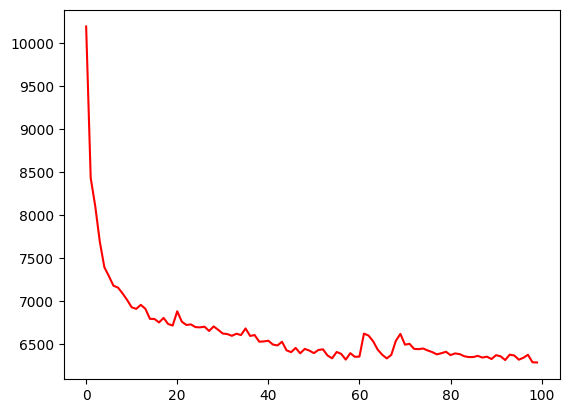

In [19]:
test_accs, test_losses, losses, train_accs, best_model, best_acc = train(args)

print("Maximum test set accuracy: {0}".format(max(test_accs)))
print("Maximum training set accuracy: {0}".format(max(train_accs)))
print("Minimum loss: {0}".format(min(losses)))
print("Minimum test loss: {0}".format(min(test_losses)))

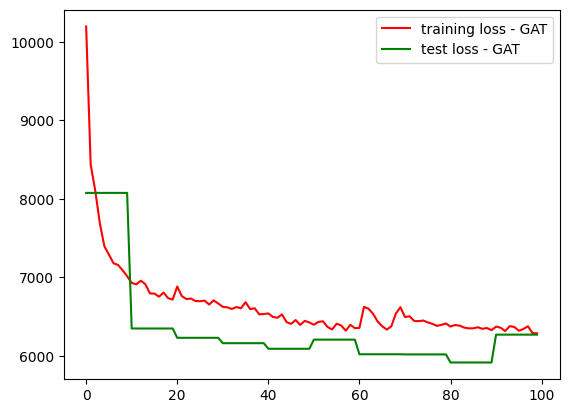

In [26]:
test_losses = [x.cpu() for x in test_losses]
train_size = MinCostDataset(root = "./data/data_train").len()
test_size = MinCostDataset(root = "./data/data_test").len()

if args.predict_edges:
    # If performing edge classification, we also plot accuracy
    plt.subplot(1, 2, 1)
fig = plt.figure(figsize=(8,4))
plt.plot(np.array(losses)/train_size, label = "training loss" + " - " + args.model_type, color = 'red', linestyle = 'solid')
plt.plot(np.array(test_losses)/test_size, label = "test loss" + " - " + args.model_type, color = 'green', linestyle = 'solid')
plt.xlabel('Epoch')
plt.ylabel('Avg loss per network')
plt.legend()

if args.predict_edges:
    plt.subplot(1, 2, 2)
    plt.plot(train_accs, label = "training accuracy" + " - " + args.model_type, color = 'red', linestyle = 'dashed')
    plt.plot(test_accs, label = "test accuracy" + " - " + args.model_type, color = 'green', linestyle = 'dashed')
    plt.legend()
    
    plt.tight_layout()
plt.show()

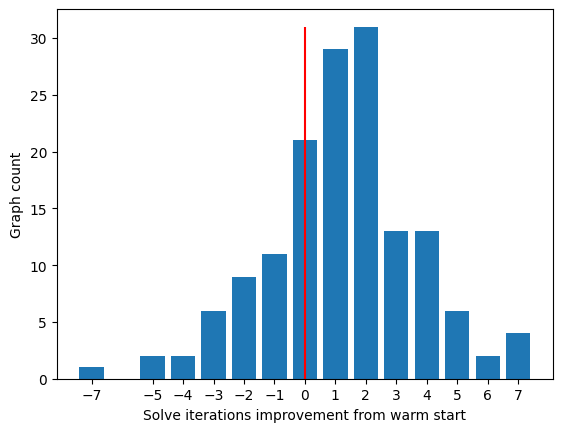

In [49]:
import importlib
import metrics
importlib.reload(metrics)
from metrics import compute_dataset_metrics

test_dataset = MinCostDataset(root = "./data/data_test")
o_iters, t_iters, o_excess, t_excess, files = compute_dataset_metrics(
    test_dataset, best_model.to('cpu'), dataset.raw_dir
)

iter_improve = np.array(o_iters) - np.array(t_iters)
labels, counts = np.unique(iter_improve, return_counts=True)
plt.bar(labels, counts, align='center')
plt.gca().set_xticks(labels)
plt.xlabel('Solve iterations improvement from warm start')
plt.ylabel('Graph count')
plt.vlines(x=-0, ymin=0, ymax=np.max(counts), color='r', linestyle='-', label='Reduced computation')
plt.show()

avg_improvement = np.mean((np.array(o_iters) - np.array(t_iters)) / np.array(o_iters))
print(f"Average runtime reduction: {avg_improvement * 100}%")